<a href="https://colab.research.google.com/github/Mahdi-Kriaa/food_sales_prediction/blob/main/food_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Data

In [2]:
file_id = "1syH81TVrbBsdymLT_jl2JIf6IjPXtSQw"

In [3]:
df_sales = pd.read_csv(f"https://docs.google.com/uc?id={file_id}")

# Cleaning Data

In [4]:
df_sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
#number of rows and columns
df_sales.shape

(8523, 12)

In [6]:
#datatypes of each variable
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
#checking if are there duplicates
df_sales.duplicated().any()

False

There is no duplicates in the data set

In [8]:
#number of missing values for each variable
number_of_missing_values = df_sales.isna().sum()
number_of_missing_values

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
df_grouped_by_items = df_sales.groupby("Item_Identifier").first()
df_grouped_by_stores = df_sales.groupby("Outlet_Identifier").first()

In [10]:
list_items = df_grouped_by_items[df_grouped_by_items.Item_Weight.isna()].index.to_list()
print("Items that have missing weights values over all the dataset :",list_items)
print(f"Percentage compared with the all missing values : {df_sales[df_sales.Item_Identifier.isin(list_items)].shape[0]/number_of_missing_values['Item_Weight']*100} %")
print(f"Percentage compared with the dataset size : {df_sales[df_sales.Item_Identifier.isin(list_items)].shape[0]/df_sales.shape[0]*100} %")

Items that have missing weights values over all the dataset : ['FDE52', 'FDK57', 'FDN52', 'FDQ60']
Percentage compared with the all missing values : 0.2734107997265892 %
Percentage compared with the dataset size : 0.04693183151472486 %


the percentage compared with the dataset size is not significant so we can drop raws that contain these items

In [11]:
df_sales.drop(df_sales[df_sales.Item_Identifier.isin(list_items)].index,inplace=True)
df_sales.reset_index(drop=True,inplace=True)

In [12]:
#replacing the other missing weight values
item_weights = df_sales.groupby("Item_Identifier").first().Item_Weight
for i in range(df_sales.shape[0]) :
  if df_sales.Item_Weight.isna()[i] :
    item = df_sales.loc[i,"Item_Identifier"]
    df_sales.loc[i,"Item_Weight"] = item_weights[item]

In [13]:
list_stores = df_grouped_by_stores[df_grouped_by_stores.Outlet_Size.isna()].index.to_list()
print("Items that have missing weights values over all the dataset :",list_stores)
print(f"Percentage compared with the all missing values : {df_sales[df_sales.Outlet_Identifier.isin(list_stores)].shape[0]/number_of_missing_values['Outlet_Size']*100} %")
print(f"Percentage compared with the dataset size : {df_sales[df_sales.Outlet_Identifier.isin(list_stores)].shape[0]/df_sales.shape[0]*100} %")

Items that have missing weights values over all the dataset : ['OUT010', 'OUT017', 'OUT045']
Percentage compared with the all missing values : 100.0 %
Percentage compared with the dataset size : 28.2897053644794 %


The percentage compared with the dataset size is significant so we can't drop raws that contain missing values

<Axes: xlabel='Outlet_Size', ylabel='Outlet_Type'>

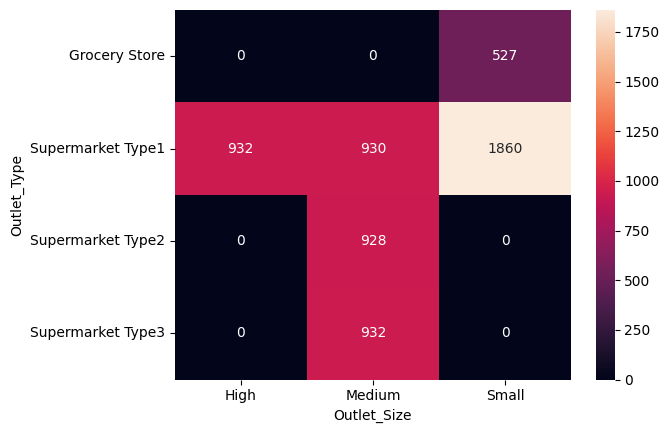

In [14]:
contingency_table = pd.crosstab(df_sales['Outlet_Type'],df_sales['Outlet_Size'])
sns.heatmap(contingency_table, annot=True, fmt='d')

In [15]:
#Identying types of stores with missing size values
df_sales[df_sales.Outlet_Identifier.isin(list_stores)].Outlet_Type.unique()

array(['Grocery Store', 'Supermarket Type1'], dtype=object)

We notice that grocery stores are all small and supermarkets type 1 are more likely to be small

In [16]:
#replacing missing stores sizes
df_sales.Outlet_Size.fillna("Small",inplace=True)

In [17]:
#checking that there are no missing values after
df_sales.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [18]:
for c in ["Item_Fat_Content","Item_Type","Outlet_Size","Outlet_Location_Type"] :
  print(f"{c} elements : {df_sales[c].unique()}")

Item_Fat_Content elements : ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type elements : ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Size elements : ['Medium' 'Small' 'High']
Outlet_Location_Type elements : ['Tier 1' 'Tier 3' 'Tier 2']


In [19]:
#fixing any inconsistent categories of data
df_sales.replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg':'Regular'},inplace=True)

In [20]:
df_sales.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Data Exploration

array([[<Axes: title={'center': 'Item_Weight'}>,
        <Axes: title={'center': 'Item_Visibility'}>],
       [<Axes: title={'center': 'Item_MRP'}>,
        <Axes: title={'center': 'Outlet_Establishment_Year'}>],
       [<Axes: title={'center': 'Item_Outlet_Sales'}>, <Axes: >]],
      dtype=object)

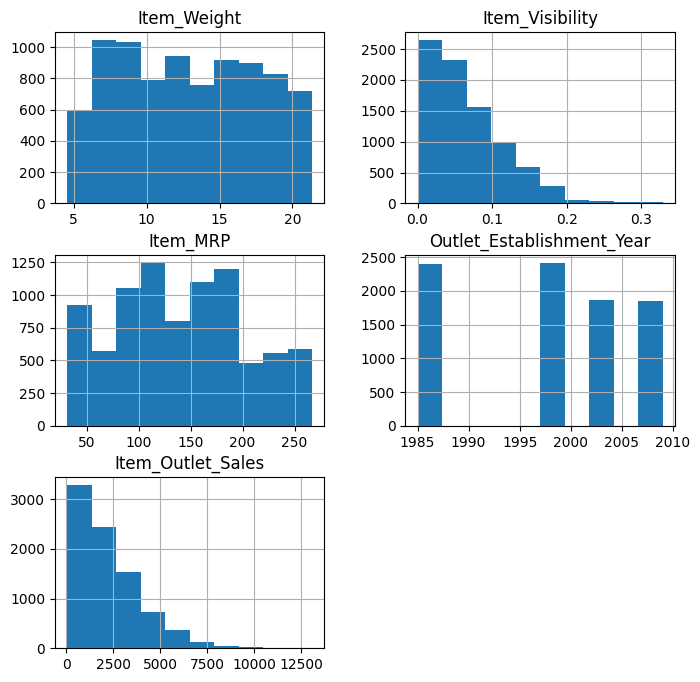

In [21]:
#Distributions of numerical columns
df_sales.hist(figsize=(8,8))

<Axes: xlabel='Item_Type', ylabel='Item_Outlet_Sales'>

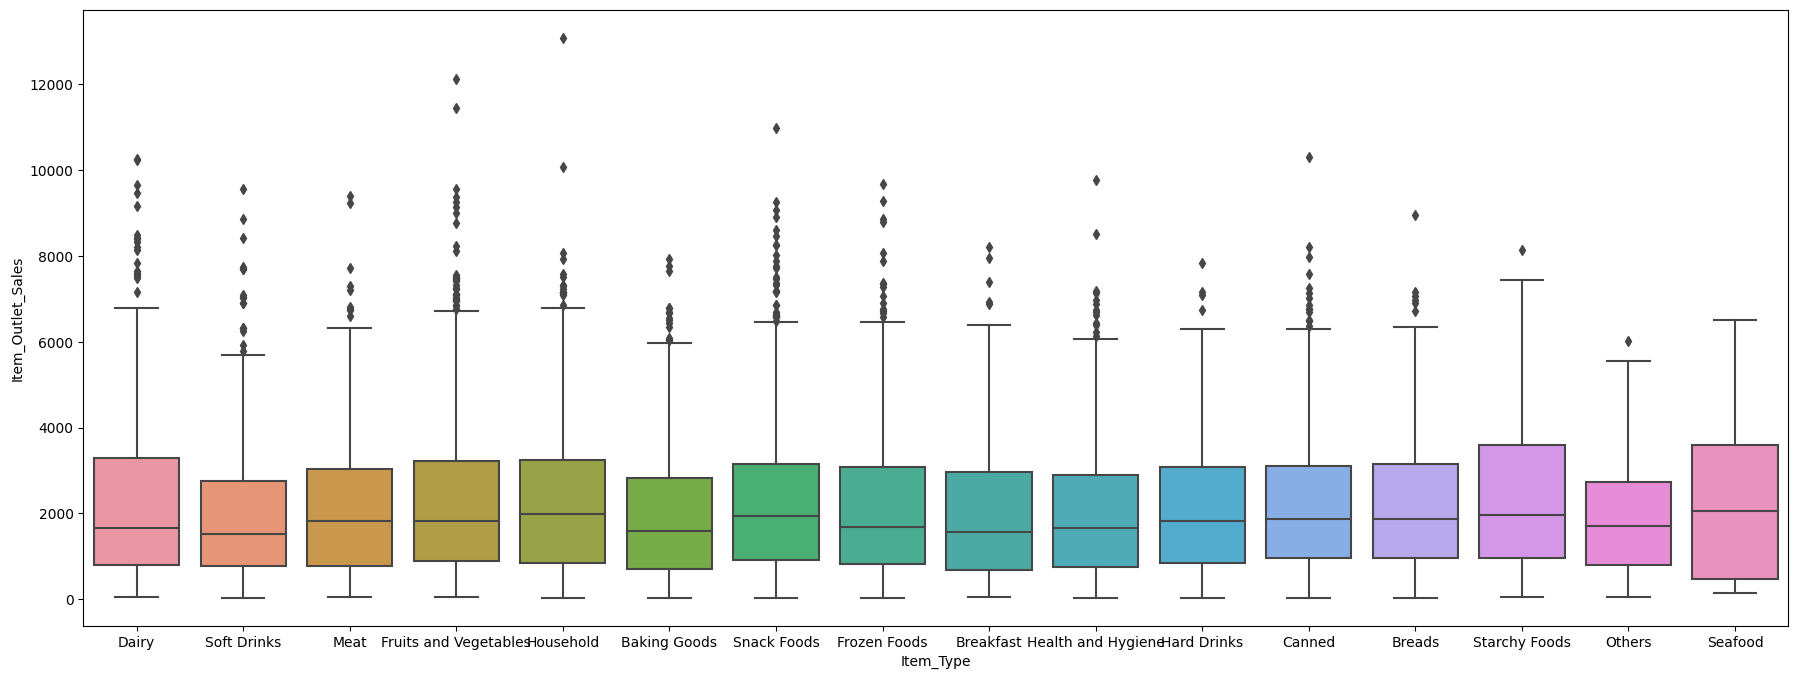

In [22]:
plt.figure(figsize=(22,8))
sns.boxplot(data=df_sales,x="Item_Type",y="Item_Outlet_Sales")

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

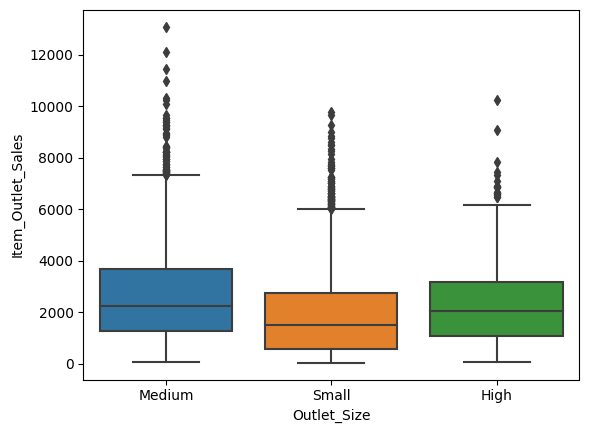

In [23]:
sns.boxplot(data=df_sales,x="Outlet_Size",y="Item_Outlet_Sales")

<Axes: xlabel='Item_Type', ylabel='Item_Visibility'>

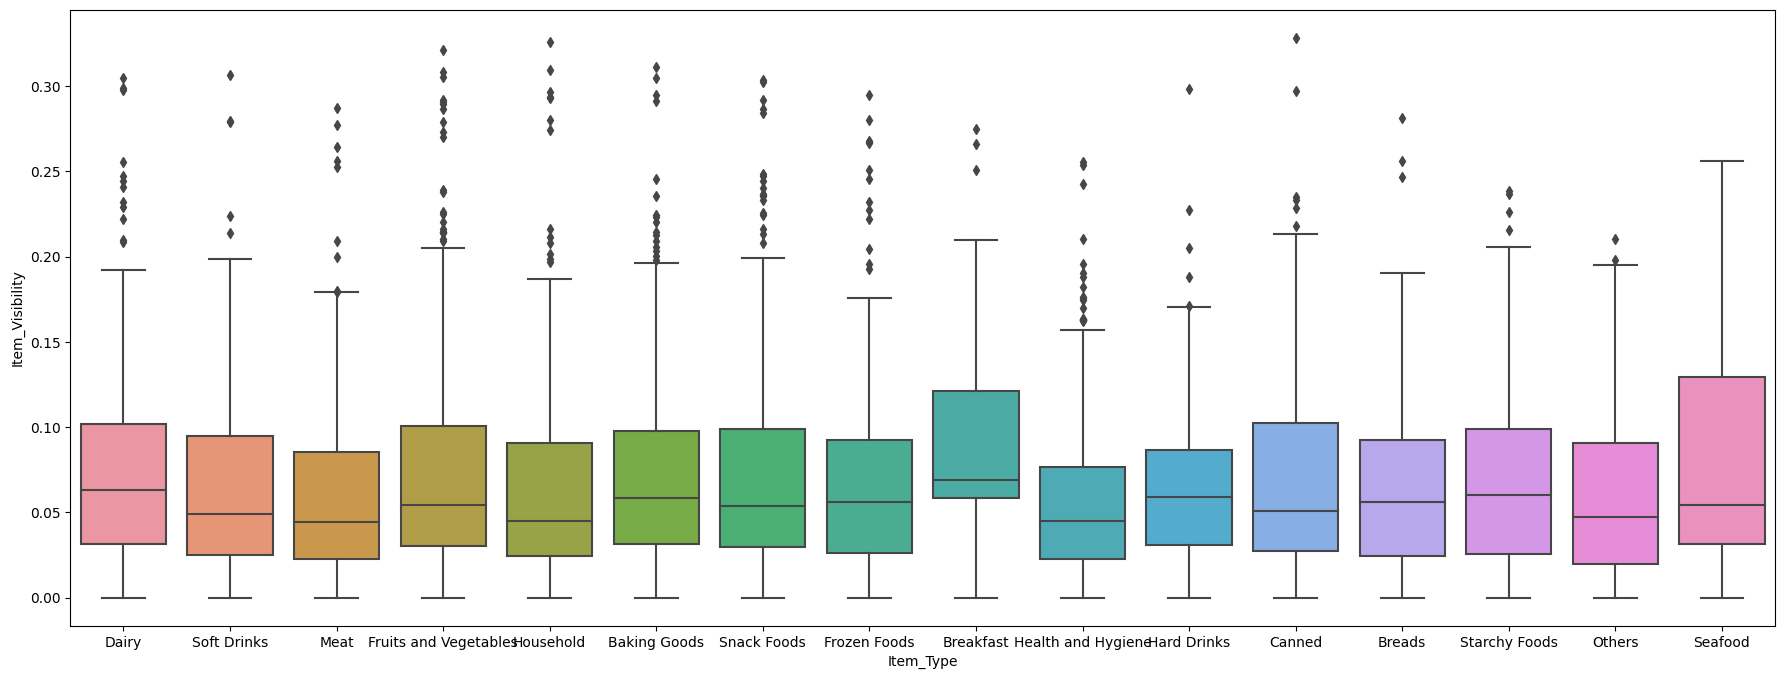

In [26]:
plt.figure(figsize=(22,8))
sns.boxplot(data=df_sales,x="Item_Type",y="Item_Visibility")

<ipython-input-27-25cad4bd2285>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_sales.corr(),annot=True,cmap="rocket_r")


<Axes: >

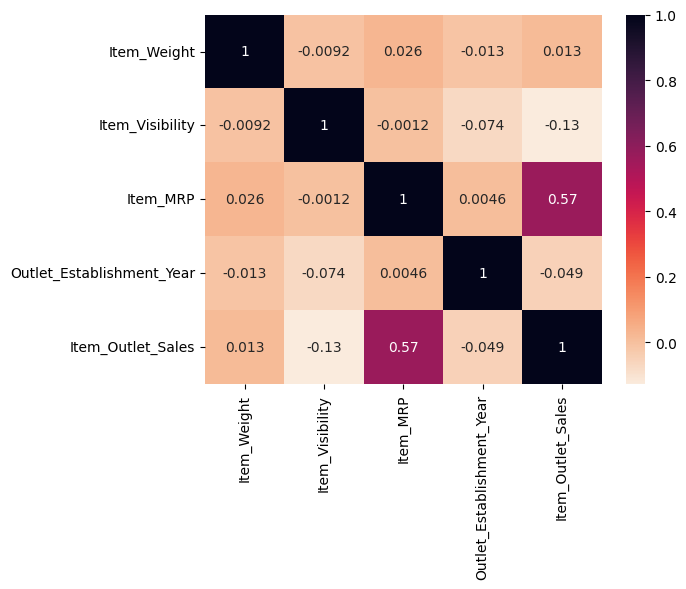

In [27]:
sns.heatmap(df_sales.corr(),annot=True,cmap="rocket_r")